### Homework 3:  Regression Challenge

Your homework assignment will be to synthesize the lessons taught in Unit 3, and present a coherent walk through of how you approached the modeling process.

**What You Will Turn In:**

A jupyter notebook with code and commentary that walks us through the following:

 - Exploratory Data Analysis on the original data
   - What are general patterns within the target variable? 
   - What relationships can we deduce from the features in X and how they relate to one another?  How they impact y?
   
 - What were some of the challenges in dealing with this dataset and why?
 - How did you separate training, validation and test sets?  Why?
 - The use of pipelines to streamline your data processing and ensure correct alignment between training and test sets
 - Strategies you used to try and improve your score (it's okay if they didn't work -- just show us what you tried to do and why)
 - What features ended up having important causal impact on the target variable?  Can you demonstrate this graphically?
 - How did you choose your model parameters?
 - How did you validation predictions compare with your test set predictions?  Can you visualize this graphically?
  
The end result should be a coherent walk through of how you approached the problem and developed a coherent solution to model your data.

**Datasets You Can Work With:**

Here are the list of the current datasets you have at your disposal:

`housing.csv` **beginner difficulty** -- this is the boston housing dataset that was used in class.  It contains 13 columns, and the target variable would be `PRICE`.  It states the sale price, and columns associated with the house's location, zoning details, and physical characteristics.  It has no missing values, no time column, and no categorical variables, so it's the most straight forward to work with.

`insurance_premiums.csv` **beginner difficulty** -- this dataset is a collection of insurance customers with columns describing some of their characteristics (age, bmi, smoking status, etc) and how much they ended up paying in insurance premiums as a result.  It is slightly more involved than `housing.csv`, since it has categorical variables.  This dataset is a useful exercise in understanding how different variables can interact with one another to impact the outcome being studied.

`bikeshare.csv` **intermediate difficulty** -- this is the dataset that was part of your bonus assignment.  It represents the number of bike rentals every hour in Manhattan during the course of several years.  This dataset is a **time series**, so it's important to make judicious use of time-based data, and to make sure you cross-validate your results sequentially.

`iowa_mini.csv` **intermediate difficulty** -- this is the dataset that we've worked on throughout class for the past two weeks. It has a few outliers within it, as well as some missing values that make it a bit challenging. It's a good idea for people who feel most comfortable continuing what was done in class.

`iowa_full.csv` **advanced difficulty** -- this is the complete iowa dataset, which has a total of 80+ columns.  Most of these are redundant, but deciphering how to best make use of them is a lot more work than the other files listed here.  With this dataset, expect to spend a lot of time cleaning your data, and deciphering how different columns ought to be encoded.

In [571]:
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
pd.options.plotting.backend = 'plotly'
import plotly.express as px
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import tree
from sklearn.pipeline import make_pipeline
from pdpbox import pdp, info_plots
from sklearn.ensemble import GradientBoostingRegressor

In [572]:
df = pd.read_csv('/Users/mcs275/dat-class-repo/Homework/Unit2/data/bikeshare.csv',parse_dates=['datetime'])

# Data Exploration and visualization

In [573]:
df

datetime  season  holiday  workingday      weather   temp  \
0     2011-01-01 00:00:00  Spring        0           0  Clear Skies   9.84   
1     2011-01-01 01:00:00  Spring        0           0  Clear Skies   9.02   
2     2011-01-01 02:00:00  Spring        0           0  Clear Skies   9.02   
3     2011-01-01 03:00:00  Spring        0           0  Clear Skies   9.84   
4     2011-01-01 04:00:00  Spring        0           0  Clear Skies   9.84   
...                   ...     ...      ...         ...          ...    ...   
10881 2012-12-19 19:00:00  Winter        0           1  Clear Skies  15.58   
10882 2012-12-19 20:00:00  Winter        0           1  Clear Skies  14.76   
10883 2012-12-19 21:00:00  Winter        0           1  Clear Skies  13.94   
10884 2012-12-19 22:00:00  Winter        0           1  Clear Skies  13.94   
10885 2012-12-19 23:00:00  Winter        0           1  Clear Skies  13.12   

        atemp  humidity  windspeed  count  
0      14.395        81     0.0000     16  
1      13.635        80     0.0000     40  
2      13.635        80     0.0000     32  
3      14.395        75     0.0000     13  
4      14.395        75     0.0000      1  
...       ...       ...        ...    ...  
10881  19.695        50    26.0027    336  
10882  17.425        57    15.0013    241  
10883  15.910        61    15.0013    168  
10884  17.425        61     6.0032    129  
10885  16.665        66     8.9981     88  

[10886 rows x 10 columns]

In [574]:
df.isnull().sum()
##confirming there are no nulls

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
dtype: int64

In [575]:
df.describe()
##count of bikeshares per hour ranges from 1 to 977, avg of 191, median 145

holiday    workingday         temp         atemp      humidity  \
count  10886.000000  10886.000000  10886.00000  10886.000000  10886.000000   
mean       0.028569      0.680875     20.23086     23.655084     61.886460   
std        0.166599      0.466159      7.79159      8.474601     19.245033   
min        0.000000      0.000000      0.82000      0.760000      0.000000   
25%        0.000000      0.000000     13.94000     16.665000     47.000000   
50%        0.000000      1.000000     20.50000     24.240000     62.000000   
75%        0.000000      1.000000     26.24000     31.060000     77.000000   
max        1.000000      1.000000     41.00000     45.455000    100.000000   

          windspeed         count  
count  10886.000000  10886.000000  
mean      12.799395    191.574132  
std        8.164537    181.144454  
min        0.000000      1.000000  
25%        7.001500     42.000000  
50%       12.998000    145.000000  
75%       16.997900    284.000000  
max       56.996900    977.000000

In [576]:
##looking at the frequency distribution of bike share counts -- left skewed, most hours have low counts
fig = px.histogram(df, x="count", nbins=100)
fig.show()

In [577]:
##creating date (no time) and time only variables in case those are significant factors (separate from datetime) in bike shares rented
df['day_of_week'] = df['datetime'].dt.day_of_week
df['time'] = df['datetime'].dt.time
df['year'] = df['datetime'].dt.year
df['date'] = df['datetime'].dt.date


In [578]:
df

datetime  season  holiday  workingday      weather   temp  \
0     2011-01-01 00:00:00  Spring        0           0  Clear Skies   9.84   
1     2011-01-01 01:00:00  Spring        0           0  Clear Skies   9.02   
2     2011-01-01 02:00:00  Spring        0           0  Clear Skies   9.02   
3     2011-01-01 03:00:00  Spring        0           0  Clear Skies   9.84   
4     2011-01-01 04:00:00  Spring        0           0  Clear Skies   9.84   
...                   ...     ...      ...         ...          ...    ...   
10881 2012-12-19 19:00:00  Winter        0           1  Clear Skies  15.58   
10882 2012-12-19 20:00:00  Winter        0           1  Clear Skies  14.76   
10883 2012-12-19 21:00:00  Winter        0           1  Clear Skies  13.94   
10884 2012-12-19 22:00:00  Winter        0           1  Clear Skies  13.94   
10885 2012-12-19 23:00:00  Winter        0           1  Clear Skies  13.12   

        atemp  humidity  windspeed  count  day_of_week      time  year  \
0      14.395        81     0.0000     16            5  00:00:00  2011   
1      13.635        80     0.0000     40            5  01:00:00  2011   
2      13.635        80     0.0000     32            5  02:00:00  2011   
3      14.395        75     0.0000     13            5  03:00:00  2011   
4      14.395        75     0.0000      1            5  04:00:00  2011   
...       ...       ...        ...    ...          ...       ...   ...   
10881  19.695        50    26.0027    336            2  19:00:00  2012   
10882  17.425        57    15.0013    241            2  20:00:00  2012   
10883  15.910        61    15.0013    168            2  21:00:00  2012   
10884  17.425        61     6.0032    129            2  22:00:00  2012   
10885  16.665        66     8.9981     88            2  23:00:00  2012   

             date  
0      2011-01-01  
1      2011-01-01  
2      2011-01-01  
3      2011-01-01  
4      2011-01-01  
...           ...  
10881  2012-12-19  
10882  2012-12-19  
10883  2012-12-19  
10884  2012-12-19  
10885  2012-12-19  

[10886 rows x 14 columns]

## Time and day of week

In [579]:
##looking at time of day and average count of bike shares
##highest bike shares during evening and morning commute times
df.groupby('time')['count'].mean().sort_values(ascending = False)

time
17:00:00    468.765351
18:00:00    430.859649
08:00:00    362.769231
16:00:00    316.372807
19:00:00    315.278509
13:00:00    257.787281
12:00:00    256.508772
15:00:00    254.298246
14:00:00    243.442982
20:00:00    228.517544
09:00:00    221.780220
07:00:00    213.116484
11:00:00    210.674725
10:00:00    175.092308
21:00:00    173.370614
22:00:00    133.576754
23:00:00     89.508772
06:00:00     76.259341
00:00:00     55.138462
01:00:00     33.859031
02:00:00     22.899554
05:00:00     19.767699
03:00:00     11.757506
04:00:00      6.407240
Name: count, dtype: float64

In [580]:
group = df.groupby('time')['count'].mean()
fig = px.bar(group)
fig.show()

In [581]:
##morning and evening commute hours are highest but still a high-ish number of bike shares during afternoon
#might want to create variable grouping hours into early morning, morn, midday, afternoon, evening?

In [582]:
df.groupby('day_of_week')['count'].mean().sort_values(ascending = False)
##not necessarily split by weekday weekend in terms of highest avg bikeshares

day_of_week
4    197.844343
3    197.296201
5    196.665404
0    190.390716
1    189.723847
2    188.411348
6    180.839772
Name: count, dtype: float64

In [583]:
df.groupby('workingday')['count'].mean()
##average bike shares lower during weekend but Saturday avg is actually higher than some work days

workingday
0    188.506621
1    193.011873
Name: count, dtype: float64

In [584]:
df.groupby('holiday')['count'].mean()

holiday
0    191.741655
1    185.877814
Name: count, dtype: float64

## Weather and seasonality

In [585]:
df.groupby('weather')['count'].mean()
##interesting that heavy storms/rain has 2nd highest avg by weather -- subway/bus issues?

weather
Clear Skies          205.236791
Heavy Storms/Rain    164.000000
Light Storms/Rain    118.846333
Partly Cloudy        178.955540
Name: count, dtype: float64

In [586]:
group = df.groupby('weather')['count'].mean().reset_index()
px.bar(group, x='weather', y='count', title = 'Average hourly bike shares by type of weather', height=400)

##lowest avg bikeshares when light storms rain rather than heavy storms/rain? highest during clear skies

In [587]:
group = df.groupby('temp')['count'].mean().reset_index(drop =  True)
px.scatter(group, trendline = 'ols', height=400)
##as temps increase, so do bikeshares on average-- might diminish at certain higher temps(above 40ish)

In [588]:
##total count of bikeshares by season
df.groupby('season')['count'].sum()

season
Fall      640662
Spring    312498
Summer    588282
Winter    544034
Name: count, dtype: int64

In [589]:
###visualizing potential relationships between variables and bikeshare
df.groupby('season')['count'].mean()

##highest average hourly count of bikeshares is highest in fall, lowest in spring


season
Fall      234.417124
Spring    116.343261
Summer    215.251372
Winter    198.988296
Name: count, dtype: float64

In [590]:
##looking into why spring is lowest -- weather or temp related?
df.groupby('season')['temp'].mean().sort_values()
##temp was lower on average in spring than in winter

season
Spring    12.530491
Winter    16.649239
Summer    22.823483
Fall      28.789111
Name: temp, dtype: float64

In [591]:
px.box(df, x='season',y='temp', title='Distribution of temps by season')
##temps actually higher in fall than other seasons, and lowest in spring

In [592]:
px.scatter(df, x='temp',y='count', facet_row='season', trendline='ols')
##The relationship between temp & bike share count are same in all seasons

In [593]:
group = df.groupby('windspeed')['count'].mean().reset_index()
px.scatter(group, x='windspeed',y='count', trendline = 'ols', height=300)
##windspeed seems to mostly have an effect on bike shares at the extreme end of very windy days, could be related to weather/temp

In [594]:
px.bar(df, x='season', y='count', facet_col='weather', title = 'Count of bike shares by season and weather')
##spring is lower even when weather is clear skies, maybe more about temp than "weather"

In [595]:
group = df.groupby('date')['count'].sum().reset_index()
px.line(group, x='date', y = 'count', title = 'Total count of bike shares by date')
#seasonal(weather) trend within a longer term trend of increasing bike share counts over time
#bike shares increased over time maybe as program ramped up/expanded to new neighborhoods

## Data preparation

In [596]:
##ensure dataset in date time order
df = df.sort_values(['datetime'])

In [597]:
##changing the time column to just the hour as integer
df['time'] = df['datetime'].dt.hour

In [598]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count', 'day_of_week', 'time',
       'year', 'date'],
      dtype='object')

In [599]:
##splitting X and y and creating training and test sets
X = df.drop(['datetime','count','date'], axis=1)
y = df['count']

# create in sample / out-of-sample splits -- last ~20% is test set, last 20% of training is validation
# because time series data, not splitting randomly but leaving later data points for the test set
X_train = X.iloc[:-2177]
X_test  = X.iloc[-2177:]

y_train = y.iloc[:-2177]
y_test  = y.iloc[-2177:]

In [600]:
X_train

season  holiday  workingday      weather   temp   atemp  humidity  \
0     Spring        0           0  Clear Skies   9.84  14.395        81   
1     Spring        0           0  Clear Skies   9.02  13.635        80   
2     Spring        0           0  Clear Skies   9.02  13.635        80   
3     Spring        0           0  Clear Skies   9.84  14.395        75   
4     Spring        0           0  Clear Skies   9.84  14.395        75   
...      ...      ...         ...          ...    ...     ...       ...   
8704    Fall        0           0  Clear Skies  30.34  34.850        70   
8705    Fall        0           0  Clear Skies  30.34  34.850        70   
8706    Fall        0           0  Clear Skies  29.52  34.850        74   
8707    Fall        0           0  Clear Skies  29.52  34.850        74   
8708    Fall        0           0  Clear Skies  29.52  34.850        74   

      windspeed  day_of_week  time  year  
0        0.0000            5     0  2011  
1        0.0000            5     1  2011  
2        0.0000            5     2  2011  
3        0.0000            5     3  2011  
4        0.0000            5     4  2011  
...         ...          ...   ...   ...  
8704    16.9979            6     1  2012  
8705    19.9995            6     2  2012  
8706    16.9979            6     3  2012  
8707    16.9979            6     4  2012  
8708    16.9979            6     5  2012  

[8709 rows x 11 columns]

In [601]:
# function for getting a validation score 

def get_val_score(X, y, mod):
    X_val = X.iloc[-2177:]
    X_train = X.iloc[:-2177]

    y_val = y.iloc[-2177:]
    y_train = y.iloc[:-2177]
    mod.fit(X_train, y_train)
    return mod.score(X_val, y_val)

In [602]:
##trying different encoding methods
pipe1 = make_pipeline(ce.OrdinalEncoder(), DecisionTreeRegressor(max_depth = 5))
pipe2 = make_pipeline(ce.OneHotEncoder(use_cat_names = True), DecisionTreeRegressor(max_depth = 5))

In [603]:
get_val_score(X_train, y_train, pipe1)

0.4286082786195834

In [604]:
get_val_score(X_train, y_train, pipe2)

0.4286082786195834

In [605]:
##Not any difference between ordinal vs. onehotencoder so will use ordinal

In [606]:
X_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'day_of_week', 'time', 'year'],
      dtype='object')

In [607]:

feats = pd.DataFrame({
    'Columns': pipe1[0].transform(X_train).columns,
    'Importance': pipe1[-1].feature_importances_
}).sort_values(by = 'Importance', ascending = False)

feats

Columns  Importance
9          time    0.736549
4          temp    0.164556
2    workingday    0.032304
5         atemp    0.029070
6      humidity    0.024917
10         year    0.011627
8   day_of_week    0.000909
0        season    0.000053
1       holiday    0.000015
3       weather    0.000000
7     windspeed    0.000000

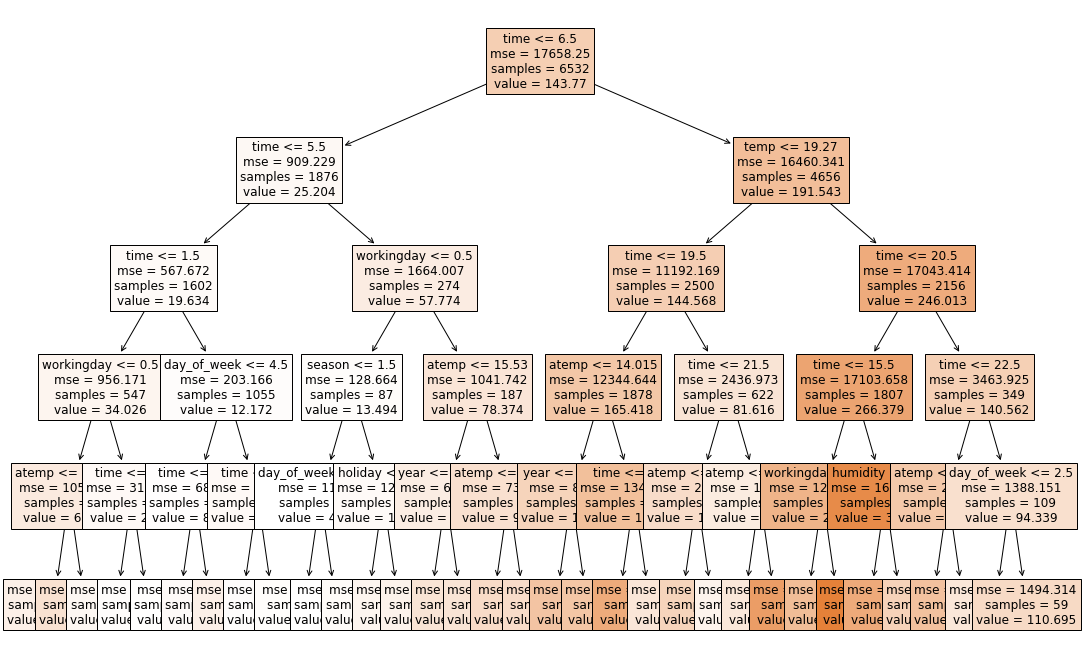

In [608]:
# plotting the tree before adding new features
plt.figure(figsize = (18, 12))

plot_tree(pipe1[1], fontsize = 12, filled = True, feature_names = pipe1[0].transform(X_train).columns);

##### initial split on time -- <6.5 (i.e. early morning) sees much lower counts, then for hours after early morning, the next split is on temp -- warmer will have higher counts of bike shares

### adding new features

In [609]:
##create variable for time categories based on trends in charts from part 1
##counts much higher during rush hour and a bit higher during midday

conditions = [np.logical_and(df['time'] >= 0, df['time']<7),
              np.logical_and(df['time'] >= 7, df['time']<10) ,
              np.logical_and(df['time'] >= 10, df['time']<17),
              np.logical_and(df['time'] >= 17, df['time']<20),
              df['time'] >= 20
             ]

results    = [
    'Early morn',
    'AM rush',
    'Midday',
    'PM rush',
    'Night'
]

df['time_of_day'] = np.select(conditions, results, 'Other')


In [610]:
X = df.drop(['datetime','count','date'], axis=1)
y = df['count']

# create in sample / out-of-sample splits /  and validation set -- last ~20% is test set, last 20% of training is validation
X_train = X.iloc[:-2177]
X_test  = X.iloc[-2177:]

y_train = y.iloc[:-2177]
y_test  = y.iloc[-2177:]

In [611]:
pipe = make_pipeline(ce.OrdinalEncoder(), DecisionTreeRegressor(max_depth = 5))
get_val_score(X_train, y_train, pipe)

0.4286082786195834

In [612]:
### time is still most important feature
feats = pd.DataFrame({
    'Columns': pipe[0].transform(X_train).columns,
    'Importance': pipe[-1].feature_importances_
}).sort_values(by = 'Importance', ascending = False)

feats

Columns  Importance
9          time    0.673651
4          temp    0.165563
11  time_of_day    0.062898
2    workingday    0.032304
5         atemp    0.028063
6      humidity    0.024917
10         year    0.011627
8   day_of_week    0.000909
0        season    0.000053
1       holiday    0.000015
3       weather    0.000000
7     windspeed    0.000000

In [613]:
## time most important

In [614]:
##Try dropping time and just using time_of_day

X_train2 = X_train.drop(['time'], axis =1)

In [615]:
pipe = make_pipeline(ce.OrdinalEncoder(), DecisionTreeRegressor(max_depth = 5))
get_val_score(X_train2, y_train, pipe)

0.4300043270848103

In [616]:
#### only slightly better with time of day categorical instead of time but will keep categorical feature

In [617]:
##trying encoding time of day with OHE instead of ordinal
pipe3 = make_pipeline(ce.OneHotEncoder(cols='time_of_day', use_cat_names = True),
                     ce.OrdinalEncoder(),
                     DecisionTreeRegressor(max_depth = 6))
get_val_score(X_train2, y_train, pipe3)

0.5388312206832837

In [618]:
##OHE time of day leads to  better val score than using ordinal so will keep time of day witth OHE

In [619]:

feats = pd.DataFrame({
    'Columns': pipe3[0].transform(X_train2).columns,
    'Importance': pipe3[-1].feature_importances_
}).sort_values(by = 'Importance', ascending = False)

feats

##early morning most important feature 

Columns  Importance
10  time_of_day_Early morn    0.439520
13     time_of_day_PM rush    0.143299
5                    atemp    0.099899
4                     temp    0.081612
11     time_of_day_AM rush    0.071925
14       time_of_day_Night    0.042617
2               workingday    0.029151
0                   season    0.024903
8              day_of_week    0.023518
6                 humidity    0.022461
9                     year    0.014696
3                  weather    0.005772
7                windspeed    0.000628
1                  holiday    0.000000
12      time_of_day_Midday    0.000000

In [620]:
##better when time of day is encoded with OHE -- can see importance of specific time period #1

#### encoding time of day with OHE looks better so will keep this pipeline

In [621]:
X_train2

season  holiday  workingday      weather   temp   atemp  humidity  \
0     Spring        0           0  Clear Skies   9.84  14.395        81   
1     Spring        0           0  Clear Skies   9.02  13.635        80   
2     Spring        0           0  Clear Skies   9.02  13.635        80   
3     Spring        0           0  Clear Skies   9.84  14.395        75   
4     Spring        0           0  Clear Skies   9.84  14.395        75   
...      ...      ...         ...          ...    ...     ...       ...   
8704    Fall        0           0  Clear Skies  30.34  34.850        70   
8705    Fall        0           0  Clear Skies  30.34  34.850        70   
8706    Fall        0           0  Clear Skies  29.52  34.850        74   
8707    Fall        0           0  Clear Skies  29.52  34.850        74   
8708    Fall        0           0  Clear Skies  29.52  34.850        74   

      windspeed  day_of_week  year time_of_day  
0        0.0000            5  2011  Early morn  
1        0.0000            5  2011  Early morn  
2        0.0000            5  2011  Early morn  
3        0.0000            5  2011  Early morn  
4        0.0000            5  2011  Early morn  
...         ...          ...   ...         ...  
8704    16.9979            6  2012  Early morn  
8705    19.9995            6  2012  Early morn  
8706    16.9979            6  2012  Early morn  
8707    16.9979            6  2012  Early morn  
8708    16.9979            6  2012  Early morn  

[8709 rows x 11 columns]

In [622]:
## time of day and temp are most important features currently, but earlier charts showed a longer term upward trend
## even with the ups and downs from the seasons (i.e. temp) and the fluctuations throughout the day b/c of time
## so adding time since start of dataset to see if there's an increase over time as the program was more established

df['Days'] = (df['datetime'] - df['datetime'].min()).dt.days

In [623]:
df.head()

datetime  season  holiday  workingday      weather  temp   atemp  \
0 2011-01-01 00:00:00  Spring        0           0  Clear Skies  9.84  14.395   
1 2011-01-01 01:00:00  Spring        0           0  Clear Skies  9.02  13.635   
2 2011-01-01 02:00:00  Spring        0           0  Clear Skies  9.02  13.635   
3 2011-01-01 03:00:00  Spring        0           0  Clear Skies  9.84  14.395   
4 2011-01-01 04:00:00  Spring        0           0  Clear Skies  9.84  14.395   

   humidity  windspeed  count  day_of_week  time  year        date  \
0        81        0.0     16            5     0  2011  2011-01-01   
1        80        0.0     40            5     1  2011  2011-01-01   
2        80        0.0     32            5     2  2011  2011-01-01   
3        75        0.0     13            5     3  2011  2011-01-01   
4        75        0.0      1            5     4  2011  2011-01-01   

  time_of_day  Days  
0  Early morn     0  
1  Early morn     0  
2  Early morn     0  
3  Early morn     0  
4  Early morn     0

In [624]:
##recreating test and train split with Days since start of dataset included
X = df.drop(['datetime','count','date','time'], axis=1)
# create in sample / out-of-sample splits
X_train = X.iloc[:-2177]
X_test  = X.iloc[-2177:]

In [625]:
get_val_score(X_train, y_train, pipe3)

0.47864112980713225

In [626]:
pipe3

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['time_of_day'], use_cat_names=True)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=['season', 'weather'],
                                mapping=[{'col': 'season',
                                          'data_type': dtype('O'),
                                          'mapping': Spring    1
Summer    2
Fall      3
Winter    4
NaN      -2
dtype: int64},
                                         {'col': 'weather',
                                          'data_type': dtype('O'),
                                          'mapping': Clear Skies          1
Partly Cloudy        2
Light Storms/Rain    3
Heavy Storms/Rain    4
NaN                 -2
dtype: int64}])),
                ('decisiontreeregressor', DecisionTreeRegressor(max_depth=6))])

In [627]:
##validation score went down when days were added 

In [628]:
## days decreased val score but days is 2nd most important feature
feats = pd.DataFrame({
    'Columns': pipe3[0].transform(X_train).columns,
    'Importance': pipe3[-1].feature_importances_
}).sort_values(by = 'Importance', ascending = False)

feats

Columns  Importance
10  time_of_day_Early morn    0.459343
15                    Days    0.160392
13     time_of_day_PM rush    0.154001
5                    atemp    0.066161
14       time_of_day_Night    0.050990
2               workingday    0.036337
6                 humidity    0.029209
3                  weather    0.019231
4                     temp    0.016319
8              day_of_week    0.004205
12      time_of_day_Midday    0.003703
7                windspeed    0.000108
0                   season    0.000000
1                  holiday    0.000000
9                     year    0.000000
11     time_of_day_AM rush    0.000000

In [629]:
##creating variables for 1 hour, 1 day, 1 week and 1 month ago
#not accounting for only 1st 19 days of month included in dataset
df['1hourago'] = df['count'].shift(1)
df['24hourago'] = df['count'].shift(24)
df['7dayago']= df['count'].shift(7*24)
##adding a month ago feature
df['1monthago'] = df['count'].shift(19*24)

In [630]:
df.head()

datetime  season  holiday  workingday      weather  temp   atemp  \
0 2011-01-01 00:00:00  Spring        0           0  Clear Skies  9.84  14.395   
1 2011-01-01 01:00:00  Spring        0           0  Clear Skies  9.02  13.635   
2 2011-01-01 02:00:00  Spring        0           0  Clear Skies  9.02  13.635   
3 2011-01-01 03:00:00  Spring        0           0  Clear Skies  9.84  14.395   
4 2011-01-01 04:00:00  Spring        0           0  Clear Skies  9.84  14.395   

   humidity  windspeed  count  day_of_week  time  year        date  \
0        81        0.0     16            5     0  2011  2011-01-01   
1        80        0.0     40            5     1  2011  2011-01-01   
2        80        0.0     32            5     2  2011  2011-01-01   
3        75        0.0     13            5     3  2011  2011-01-01   
4        75        0.0      1            5     4  2011  2011-01-01   

  time_of_day  Days  1hourago  24hourago  7dayago  1monthago  
0  Early morn     0       NaN        NaN      NaN        NaN  
1  Early morn     0      16.0        NaN      NaN        NaN  
2  Early morn     0      40.0        NaN      NaN        NaN  
3  Early morn     0      32.0        NaN      NaN        NaN  
4  Early morn     0      13.0        NaN      NaN        NaN

In [631]:
df = df.fillna(0)

In [632]:
X = df.drop(['datetime','count','date','time'], axis=1)
# create in sample / out-of-sample splits 
X_train = X.iloc[:-2177]
X_test  = X.iloc[-2177:]

In [633]:
get_val_score(X_train, y_train, pipe3)


0.7364174262126443

In [634]:
##adding shift values greatly increased val score

In [635]:
##create rolling average for month to see if that's more important than shift values

df['rolling1month'] = df['count'].rolling(19*24).mean().shift().values
df['rolling24hrs'] = df['count'].rolling(24).mean().shift().values
df['rolling7days'] = df['count'].rolling(7*24).mean().shift().values
df = df.bfill()

In [636]:
X = df.drop(['datetime','count','date','time'], axis=1)
# create in sample / out-of-sample splits /  and validation set -- last ~20% is test set, last 20% of training is validation
X_train = X.iloc[:-2177]
X_test  = X.iloc[-2177:]

In [637]:
get_val_score(X_train, y_train, pipe3)
##not much higher with rolling averages

0.7315501429923988

In [638]:
feats = pd.DataFrame({
    'Columns': pipe3[0].transform(X_train).columns,
    'Importance': pipe3[-1].feature_importances_
}).sort_values(by = 'Importance', ascending = False)

feats

Columns  Importance
16                1hourago    0.762623
17               24hourago    0.142025
18                 7dayago    0.023073
11     time_of_day_AM rush    0.022124
12      time_of_day_Midday    0.013608
2               workingday    0.008110
8              day_of_week    0.007663
20           rolling1month    0.004983
13     time_of_day_PM rush    0.003703
21            rolling24hrs    0.002672
3                  weather    0.002523
4                     temp    0.002264
6                 humidity    0.002053
22            rolling7days    0.001024
15                    Days    0.000897
19               1monthago    0.000654
14       time_of_day_Night    0.000000
1                  holiday    0.000000
10  time_of_day_Early morn    0.000000
9                     year    0.000000
7                windspeed    0.000000
5                    atemp    0.000000
0                   season    0.000000

In [639]:
##rolling avg don't seem to contribute much 
df = df.drop(['rolling7days','rolling24hrs','rolling1month'], axis = 1)

In [640]:
X = df.drop(['datetime','count','date','time','year'], axis=1)
# create in sample / out-of-sample splits /  and validation set -- last ~20% is test set, last 20% of training is validation
X_train = X.iloc[:-2177]
X_test  = X.iloc[-2177:]

In [641]:
get_val_score(X_train, y_train, pipe3)
##not much higher with or without rolling averages
## season, atemp

0.7371639686272133

In [642]:
feats = pd.DataFrame({
    'Columns': pipe3[0].transform(X_train).columns,
    'Importance': pipe3[-1].feature_importances_
}).sort_values(by = 'Importance', ascending = False)

feats

Columns  Importance
15                1hourago    0.763877
16               24hourago    0.142089
17                 7dayago    0.024579
10     time_of_day_AM rush    0.022152
11      time_of_day_Midday    0.013625
8              day_of_week    0.007673
2               workingday    0.007673
14                    Days    0.005136
12     time_of_day_PM rush    0.003707
3                  weather    0.003327
4                     temp    0.002349
6                 humidity    0.002056
7                windspeed    0.001178
0                   season    0.000581
9   time_of_day_Early morn    0.000000
13       time_of_day_Night    0.000000
1                  holiday    0.000000
5                    atemp    0.000000
18               1monthago    0.000000

In [643]:
max_depth = [5, 6, 7]
max_features = [0.6, 0.8, 1]
min_samples_leaf = [10, 20, 40]
cv_scores = []

for depth in max_depth:
    for feature in max_features:
        for sample in min_samples_leaf:
            print(f"Getting validation score for: depth: {depth}, max_features: {feature}, leaf_samples: {sample}")
            pipe3[-1].set_params(max_depth = depth, max_features = feature, min_samples_leaf = sample)
            val_score = get_val_score(X_train, y_train, pipe3)
            cv_scores.append((val_score, depth, feature, sample))

Getting validation score for: depth: 5, max_features: 0.6, leaf_samples: 10
Getting validation score for: depth: 5, max_features: 0.6, leaf_samples: 20
Getting validation score for: depth: 5, max_features: 0.6, leaf_samples: 40
Getting validation score for: depth: 5, max_features: 0.8, leaf_samples: 10
Getting validation score for: depth: 5, max_features: 0.8, leaf_samples: 20
Getting validation score for: depth: 5, max_features: 0.8, leaf_samples: 40
Getting validation score for: depth: 5, max_features: 1, leaf_samples: 10
Getting validation score for: depth: 5, max_features: 1, leaf_samples: 20
Getting validation score for: depth: 5, max_features: 1, leaf_samples: 40
Getting validation score for: depth: 6, max_features: 0.6, leaf_samples: 10
Getting validation score for: depth: 6, max_features: 0.6, leaf_samples: 20
Getting validation score for: depth: 6, max_features: 0.6, leaf_samples: 40
Getting validation score for: depth: 6, max_features: 0.8, leaf_samples: 10
Getting validation

In [644]:
cv_scores

[(0.6462408310155998, 5, 0.6, 10),
 (0.6605122719985591, 5, 0.6, 20),
 (0.7035003474598301, 5, 0.6, 40),
 (0.6732627605234166, 5, 0.8, 10),
 (0.7056818008812562, 5, 0.8, 20),
 (0.706965162924652, 5, 0.8, 40),
 (0.28390060318173893, 5, 1, 10),
 (0.07278333635618961, 5, 1, 20),
 (0.43002399181329887, 5, 1, 40),
 (0.720525708196315, 6, 0.6, 10),
 (0.714951183246424, 6, 0.6, 20),
 (0.6929771877466449, 6, 0.6, 40),
 (0.7512558939976539, 6, 0.8, 10),
 (0.7317059026967847, 6, 0.8, 20),
 (0.7552417663661893, 6, 0.8, 40),
 (0.483540918576733, 6, 1, 10),
 (0.5514402069589074, 6, 1, 20),
 (0.4667417236982492, 6, 1, 40),
 (0.7362191613580514, 7, 0.6, 10),
 (0.7266002659803785, 7, 0.6, 20),
 (0.6992000795522405, 7, 0.6, 40),
 (0.747573356632119, 7, 0.8, 10),
 (0.7618285488059768, 7, 0.8, 20),
 (0.721137452802683, 7, 0.8, 40),
 (0.51978787876157, 7, 1, 10),
 (0.4409314702928384, 7, 1, 20),
 (0.31406034668233374, 7, 1, 40)]

In [645]:
max(cv_scores)

(0.7618285488059768, 7, 0.8, 20)

In [646]:

# set the model to the best parameters (max features has varied between .8 and .6 when the notebook has been rerun)
# max depth of 7 and min samples leaf of 10
pipe3[-1].set_params(min_samples_leaf = 10, max_features = 0.8, max_depth = 7)

DecisionTreeRegressor(max_depth=7, max_features=0.8, min_samples_leaf=10)

In [647]:
X_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'day_of_week', 'time_of_day', 'Days',
       '1hourago', '24hourago', '7dayago', '1monthago'],
      dtype='object')

##### Scoring model on test set 

In [648]:
get_val_score(X, y, pipe3)

0.8380512023931046

In [649]:
## looking at val score again for validation set 
get_val_score(X_train, y_train, pipe3)

0.7684434922064903

### test score was a bit higher than validation score

In [650]:
feats = pd.DataFrame({
    'Columns': pipe3[0].transform(X_train).columns,
    'Importance': pipe3[-1].feature_importances_
}).sort_values(by = 'Importance', ascending = False)

feats

Columns  Importance
15                1hourago    0.659652
9   time_of_day_Early morn    0.103271
16               24hourago    0.079780
17                 7dayago    0.068170
10     time_of_day_AM rush    0.027241
8              day_of_week    0.017402
13       time_of_day_Night    0.013031
14                    Days    0.008112
11      time_of_day_Midday    0.005981
12     time_of_day_PM rush    0.005374
5                    atemp    0.003399
2               workingday    0.003190
4                     temp    0.001823
6                 humidity    0.001685
18               1monthago    0.001257
0                   season    0.000453
7                windspeed    0.000091
3                  weather    0.000088
1                  holiday    0.000000

### Final analysis
#### Model is mostly using bike share count from 1 hour ago and 24 hours ago to make prediction
####  maybe 1 hour ago count captures both the affect of the avg temperature and the time of day factor, making it the most important feature? hour prior could be seen as a predictor of how "busy" the entire day will be. Might also take into account if the bike share program had expanded then you will see growth each hour, so if 7am one day is busier than usual, then 8am, 9am, etc. will also be busier than the prior day/s, etc.?

In [651]:
##visualizing the relationship
px.scatter(df, x='1hourago', y='count', trendline='ols')
# prior hour count and count are strongly correlated

### Partial Dependence Plotting

In [652]:
X_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'day_of_week', 'time_of_day', 'Days',
       '1hourago', '24hourago', '7dayago', '1monthago'],
      dtype='object')

In [653]:
# setup our model 
# defining the ordinal encoder to transform day of week in the correct order
ore  = ce.OrdinalEncoder(cols=['day_of_week','season','weather'])

# OneHot Columns That we want to look at
ohe  = ce.OneHotEncoder(cols = ['time_of_day'], use_cat_names=True)

# creating a pipe with a target encoder to catch everything else
pipe = make_pipeline(ore, ohe, ce.TargetEncoder())
# model to make predictions
mod = GradientBoostingRegressor()
# transform the data and fit
X_train = pipe.fit_transform(X_train, y_train)
mod.fit(X_train, y_train)

GradientBoostingRegressor()

In [654]:
ohe = ce.OneHotEncoder(use_cat_names = True)
ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train)

## pdp for time of day categorical 
time_of_day_cols = [col for col in X_train_ohe.columns if 'time_of_day' in col]
time_of_day_cols

['time_of_day_Early morn',
 'time_of_day_AM rush',
 'time_of_day_Midday',
 'time_of_day_PM rush',
 'time_of_day_Night']

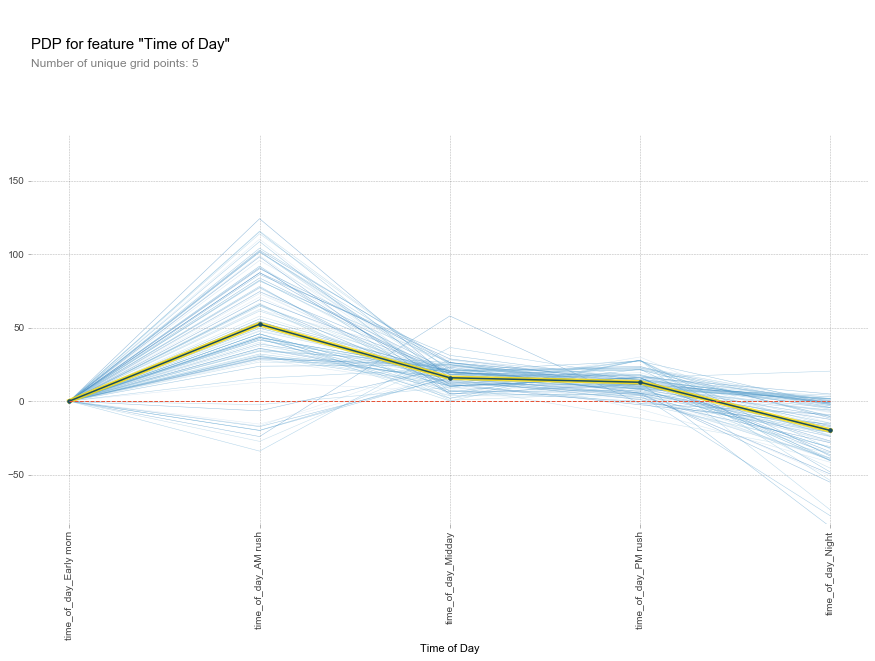

In [655]:
# impact of time of day on count
pdp_tod = pdp.pdp_isolate(
    # dataset -- create the final transformation of our data
    model=mod, dataset=X_train_ohe, model_features=X_train_ohe.columns, 
    # this is the list of all the columns for the genre feature
    feature=time_of_day_cols
)

fig, axes = pdp.pdp_plot(pdp_tod, 'Time of Day', plot_lines=True, frac_to_plot=100)
# this code is just for formatting -- getting the labels to format correctly
xtick_labels = time_of_day_cols
axes['pdp_ax'].set_xticklabels(xtick_labels, rotation='vertical');

#### count goes up during AM Rush, flat during midday and down again at night time

In [659]:
X_train_cols = X_train.columns
X_train_cols

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'day_of_week', 'time_of_day_Early morn',
       'time_of_day_AM rush', 'time_of_day_Midday', 'time_of_day_PM rush',
       'time_of_day_Night', 'Days', '1hourago', '24hourago', '7dayago',
       '1monthago'],
      dtype='object')

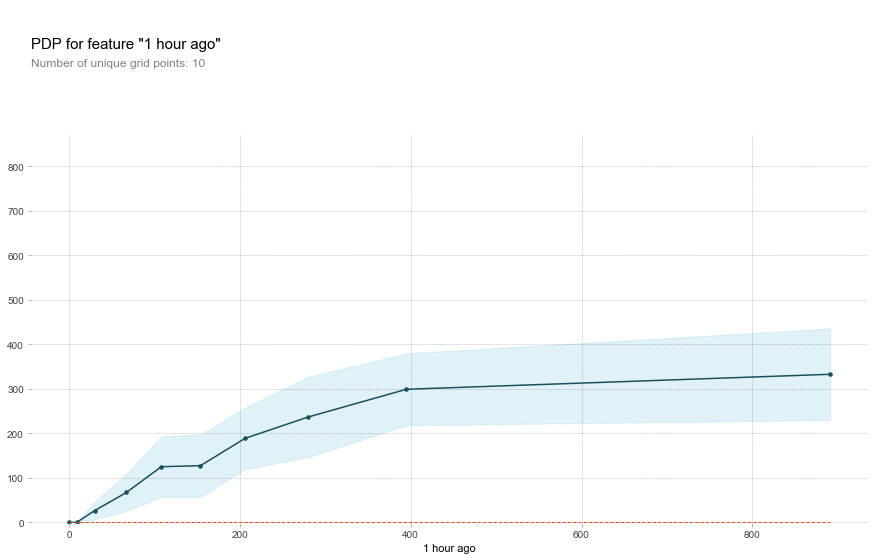

In [675]:
X_train_transformed = pipe3[1].transform(X_train)
X_train_cols = X_train_transformed.columns

pdp_1hourago = pdp.pdp_isolate(
    # this is the model with the predictions
    model = pipe3[2], 

    # we are using the training set since that is what our model was fit on
    dataset = pipe3[1].transform(X_train), 
    
    # column names from the transformed training set
    model_features = X_train_cols, 
    
    # column label
    feature = '1hourago',
)

# this part is just for formatting
fig, axes = pdp.pdp_plot(pdp_1hourago, '1 hour ago')

#### Counts increase steeply when the 1 hour ago count was 1-400 then levels off after 400

## Challenges:

### Figuring out what time dependent variables were important enough to include and/or figuring out what to drop
### The dataset only includes first 19 days of each month but not sure how to incorporate that into time-based features with longer lookback
### The time based features may include some of the effects of the other features (i.e. weather, season, day would affect more than just 1 hour and may be part of the affect of the 1 hour ago, etc. counts on the current observation's count